In [1]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node d4e6a400-466a-4476-a871-0ff69583670e

In [2]:
import Local_NAV as local
from Global_NAV import *
import Motion_CTR_ as mctrl
import Kalman_FIL as kfil
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import IPython
from IPython.display import display, clear_output
import time

from matplotlib import colors
from cvision import *

%matplotlib inline

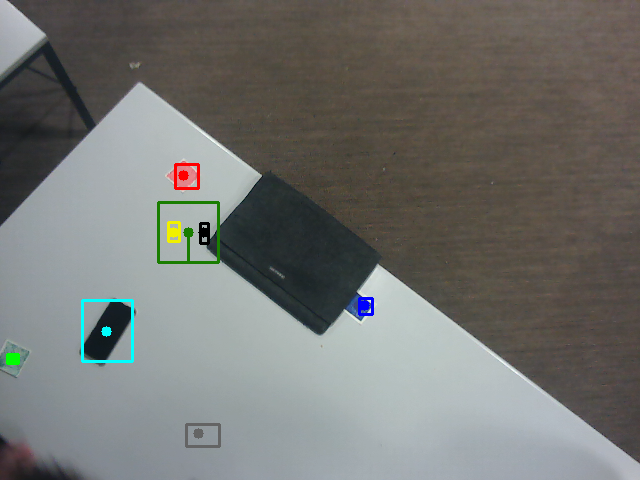

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Robot position :  [0.17464275 0.19261829]
Robot direction :  [0.72690177 0.68674145]


In [19]:
# Definition of the references used to map the space
color_ref1 = cv2.imread('ref1.jpg')
ref1 = Obj(color_ref1, 25, 3, np.array([[0,0]]))

color_ref2 = cv2.imread('ref2.jpg')
ref2 = Obj(color_ref2, 100, 2.5, np.array([[0,0]]))

color_ref3 = cv2.imread('ref3.jpg')
ref3 = Obj(color_ref3, 30, 1.5, np.array([[0,0]]))

map = Map(ref1, ref2, ref3)

# Definition of the objects to recognize in the space
color_obstacle = cv2.imread('obstacle.jpg')
obstacle = Obj(color_obstacle, 700, 2)

color_goal = cv2.imread('goal.jpg')
goal = Obj(color_goal, 100, 3)

color_left_mark = cv2.imread('left_mark.jpg')
left_mark = Obj(color_left_mark, 15, 3)

color_right_mark = cv2.imread('right_mark.jpg')
right_mark = Obj(color_right_mark, 15,3)

thymio = Robot(right_mark, left_mark)

# Open the video
video = cv2.VideoCapture(0)
if (video.isOpened()== False):
    print("Error opening video stream or file")


while(video.isOpened()):
    ret, frame = video.read()
    if ret == True:
        # Draw the objects on a copy of the frame 
        copy_f = frame.copy()
        ref1.draw(copy_f,(0, 255, 0))
        ref2.draw(copy_f,(0,0,255))
        ref3.draw(copy_f,(255, 0, 0))
        goal.draw(copy_f, (100,100,100))
        left_mark.draw(copy_f,(0, 0, 0))
        right_mark.draw(copy_f,(0, 240, 240))
        obstacle.draw(copy_f, (255, 255, 0))
        thymio.draw(copy_f, (0, 125, 25))
        #show_frame(frame)
        show_frame(copy_f)
        map_mat = map.matrix(frame, [obstacle], thymio, goal)
        print(map_mat)
        print('Robot position : ', thymio.localize(frame,map)[0])
        print('Robot direction : ', thymio.localize(frame,map)[1])
        if check_matrix(map_mat):
            print('Path :', global_path(map_mat))
            # or
            """ 
            max_val_x, max_val_y, start, end, arr = conversion(map_mat)
            h, coords = heuristics(max_val_x, max_val_y, end)
            path, visitedNodes = A_Star(start, end, h, coords, arr)
            path = np.array(path).reshape(-1, 2).transpose()
            visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
            cmap = colors.ListedColormap(['white', 'red'])
            # Displaying the map
            fig_astar, ax_astar = create_empty_plot(max_val_x, max_val_y)
            ax_astar.imshow(arr.transpose(), cmap)

            # Plot the best path found and the list of visited nodes
            ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange')
            ax_astar.plot(path[0], path[1], marker="o", color = 'blue')
            ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200)
            ax_astar.scatter(end[0], end[1], marker="o", color = 'purple', s=200)
            plt.title("best path in blue, visited nodes in orange")
            plt.title("Map : free cells in white, occupied cells in red")
            plt.show() """
            #time.sleep(1)
        
        clear_output(wait=True)
    # Break the loop
    else:
        break

# When everything done, release the video capture object
video.release()

# Closes all the frames
cv2.destroyAllWindows()

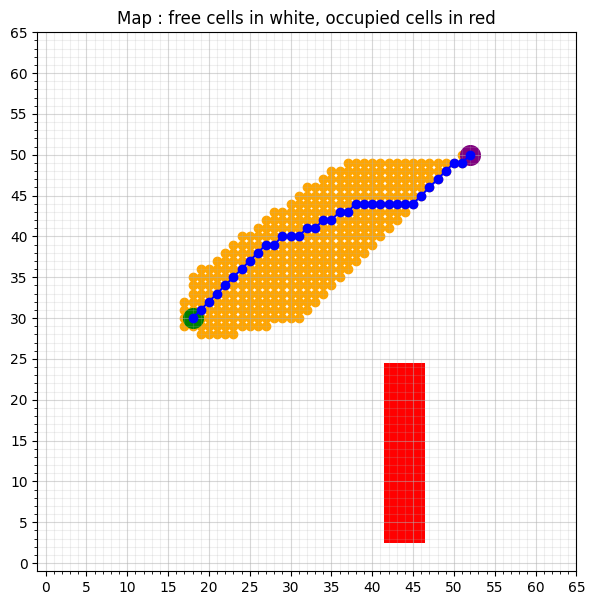

Path : [[180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
  360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520]
 [300 310 320 330 340 350 360 370 380 390 390 400 400 400 410 410 420 420
  430 430 440 440 440 440 440 440 440 440 450 460 470 480 490 490 500]]
Robot position :  [0.28029463 0.49896306]
Robot direction :  0.5299712844412666
[0.28029463 0.49896306 0.52997128]
Pth [180, 300]
v,w 42 0.4002869543328327
vr, vl :  212.342958752707 71.84862276183205
Robot position :  [0.2800818  0.50695989]
Robot direction :  0.4813638457745621
Z_k  [2.80081797e+02 5.06959891e+02 4.81363846e-01]
St est [268.76568085 486.44059729   0.48678076]
Pth [180, 300]
v,w 42 -2.0015426271673533
vr, vl :  -209.8593221875358 495.42712048262644
Robot position :  [0.2834421  0.50604472]
Robot direction :  0.48172669588050715
Z_k  [2.83442103e+02 5.06044720e+02 4.81726696e-01]
St est [2.82550707e+02 5.04815486e+02 4.65021066e-01]
Pth [180, 300]
v,w 42 -2.000018605939027
vr,

KeyboardInterrupt: 

In [14]:
#Global variables
state = 0
obst = [0,0,0,0,0]
motors_speed = [0,0]
not_arrived = True
k = 0
C_conv_toThymio_right = 67.60908181
C_conv_toThymio_left = 67.82946137
L = 104
R = 20
Ts = 0.02 # sampling time
# Initial state covariance matrix
P_k_minus_1 = np.array([[0.1, 0, 0],
                        [0, 0.1, 0],
                        [0, 0, 0.1]])
P_k = P_k_minus_1
threshold_for_convergence = 5

path = []
while True:
    if state == 0:

       # Definition of the references used to map the space
        color_ref1 = cv2.imread('ref1.jpg')
        ref1 = Obj(color_ref1, 25, 3, np.array([[0,0]]))

        color_ref2 = cv2.imread('ref2.jpg')
        ref2 = Obj(color_ref2, 100, 2.5, np.array([[0,0]]))

        color_ref3 = cv2.imread('ref3.jpg')
        ref3 = Obj(color_ref3, 30, 1.5, np.array([[0,0]]))

        map = Map(ref1, ref2, ref3)

        # Definition of the objects to recognize in the space
        color_obstacle = cv2.imread('obstacle.jpg')
        obstacle = Obj(color_obstacle, 700, 2)

        color_goal = cv2.imread('goal.jpg')
        goal = Obj(color_goal, 100, 3)

        color_left_mark = cv2.imread('left_mark.jpg')
        left_mark = Obj(color_left_mark, 25, 2.5)

        color_right_mark = cv2.imread('right_mark.jpg')
        right_mark = Obj(color_right_mark, 25, 3)

        thymio = Robot(right_mark, left_mark)


        # Open the video
        # For a livestream
        video = cv2.VideoCapture(0)
        # or with a prerecorded video
        #video = cv2.VideoCapture('test3.avi')
        if (video.isOpened()== False): 
            print("Error opening video stream or file")
        
        # Recognition of the view with the map and path planning
        path_found = False
        while not (path_found):
            ret, frame = video.read()
            if ret == True:
                copy_f = frame.copy()
                ref1.draw(copy_f,(0, 255, 0))
                ref2.draw(copy_f,(0,0,255))
                ref3.draw(copy_f,(255, 0, 0))
                goal.draw(copy_f, (100,100,100))
                left_mark.draw(copy_f,(0, 0, 0))
                right_mark.draw(copy_f,(0, 240, 240))
                obstacle.draw(copy_f, (255, 255, 0))
                thymio.draw(copy_f, (0, 125, 25))
                #show_frame(frame)
                show_frame(copy_f)
                matrix = map.matrix(frame, [obstacle], thymio, goal)
                clear_output(wait=True) 
                if check_matrix(matrix):
                    #path = global_path(matrix)
                    
                    max_val_x, max_val_y, start, end, arr = conversion(matrix)
                    h, coords = heuristics(max_val_x, max_val_y, end)
                    path, visitedNodes = A_Star(start, end, h, coords, arr, max_val_x, max_val_y)
                    path = np.array(path).reshape(-1, 2).transpose()
                    visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
                    cmap = colors.ListedColormap(['white', 'red'])
                    # Displaying the map
                    fig_astar, ax_astar = create_empty_plot(max_val_x, max_val_y)
                    ax_astar.imshow(arr.transpose(), cmap)

                    # Plot the best path found and the list of visited nodes
                    ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange')
                    ax_astar.plot(path[0], path[1], marker="o", color = 'blue')
                    ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200)
                    ax_astar.scatter(end[0], end[1], marker="o", color = 'purple', s=200)
                    plt.title("best path in blue, visited nodes in orange")
                    plt.title("Map : free cells in white, occupied cells in red")
                    plt.show()
                    path = np.multiply(path, 10)
                    N = len(path)
                    path_found = True
                    print('Path :', path)
                    print('Robot position : ', thymio.localize(frame,map)[0])
                    print('Robot direction : ', vector_to_angle(thymio.localize(frame,map)[1]))
                    state_estimate_k = np.array([thymio.localize(frame,map)[0,0],thymio.localize(frame,map)[0,1],vector_to_angle(thymio.localize(frame,map)[1])])
                    print(state_estimate_k)

        # Navigation
        state = 1    
        # Global navigation state
        if state == 1:

            while not_arrived == True:
                #Check if there is obstacles
                prox_horizontal = local.read_prox_sensors(node,client)
                obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
                state = local.update_state(state,obst,client)

                # Update temporary goal
                print("Pth", [path[0,k],path[1,k]])
                if k < N-1:
                    theta_goal_temp = (math.atan2(path[0,k+1]-path[0,k], path[1,k+1]-path[1,k]) + np.pi) % (np.pi/2) - np.pi
                v, w = mctrl.control_law(state_estimate_k, path[0,k], path[1,k], theta_goal_temp)
                print("v,w",v,w)
                vr, vl = mctrl.convert_velocity2RL(v,w,C_conv_toThymio_right, C_conv_toThymio_left,L,R)
                print("vr, vl : ",vr,vl)
                vr = int(vr)
                vl = int(vl)
                mctrl.set_motors(vl,vr,node)
                
                camera_obstructed = 1
                # Check if camera is obstructed
                if video.isOpened:
                    ret, frame = video.read()
                    if ret == True:
                        if np.size(thymio.localize(frame,map)[1], 0) > 0:
                            camera_obstructed = 0
                            #clear_output(wait=True)
                            #print('Path :', path)
                            print('Robot position : ', thymio.localize(frame,map)[0])
                            print('Robot direction : ', vector_to_angle(thymio.localize(frame,map)[1]))
                            z_k_observation_vector = np.array([1000*thymio.localize(frame,map)[0][0],1000*thymio.localize(frame,map)[0][1],vector_to_angle(thymio.localize(frame,map)[1])]) 
                            print("Z_k ", z_k_observation_vector)
                            P_k_minus_1 = P_k
                            state_estimate_k,P_k = kfil.ekf(z_k_observation_vector, state_estimate_k, [v,w] , P_k_minus_1, Ts, camera_obstructed)
                            print("St est", state_estimate_k)
                        else:
                            z_k_observation_vector = np.array([state_estimate_k[0], state_estimate_k[1], state_estimate_k[2]])
                            state_estimate_k,P_k = kfil.ekf(z_k_observation_vector, state_estimate_k, [v,w] , P_k_minus_1, Ts, camera_obstructed)

                if np.linalg.norm(state_estimate_k[:2] - np.array([path[0,k], path[1,k]])) < threshold_for_convergence:
                    k = k+1
                    if k == N-1:
                        not_arrived = False
                        print('The robot has arrived to the final goal')
                    break 
                time.sleep(Ts)
            state = 3                                               


        # Local navigation state
        if state == 2: 
            
            #We get the sensor value
            prox_horizontal = local.read_prox_sensors(node,client)
            
            #We fill the obst list with the sensor value
            obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
            
            #We calculate the motor speed to avoid the object -> potential field method
            motors_speed = local.local_navigation(obst)
            
            #We set the motor speed
            mctrl.set_motors(motors_speed[0],motors_speed[1],node)       
            
            #We update the state
            state = local.update_state(state,obst,client)   


In [ ]:
motors_speed = local.global_path()
local.set_motors(motors_speed[0],motors_speed[1],node) 
local.stop_motors(node) 


AttributeError: module 'Local_NAV' has no attribute 'global_path'

In [15]:
mctrl.stop_motors(node)